In [1]:
import sys
from scipy.optimize import linear_sum_assignment

sys.path.append("..")
from src import *

Cupy Available= 1


In [119]:
dataset = "synthetic"
folder = "fft_15"

In [120]:
dir = Path(f"dataset/{dataset}/{folder}/suite2p/plane0")
meta = DATASETS[dataset]
n_time, Ly, Lx = meta.shape

stats = np.load(dir / "stat.npy", allow_pickle=True)
ops = np.load(dir / "ops.npy", allow_pickle=True).item()
iscell = np.load(dir / "iscell.npy", allow_pickle=True)[:, 0].astype(int)
f_cells = np.load(dir / "F.npy")
f_neuropils = np.load(dir / "Fneu.npy")
spks = np.load(dir / "spks.npy")

## Registration
Registration computes a reference image from a subset of frames and registers all frames to the reference.

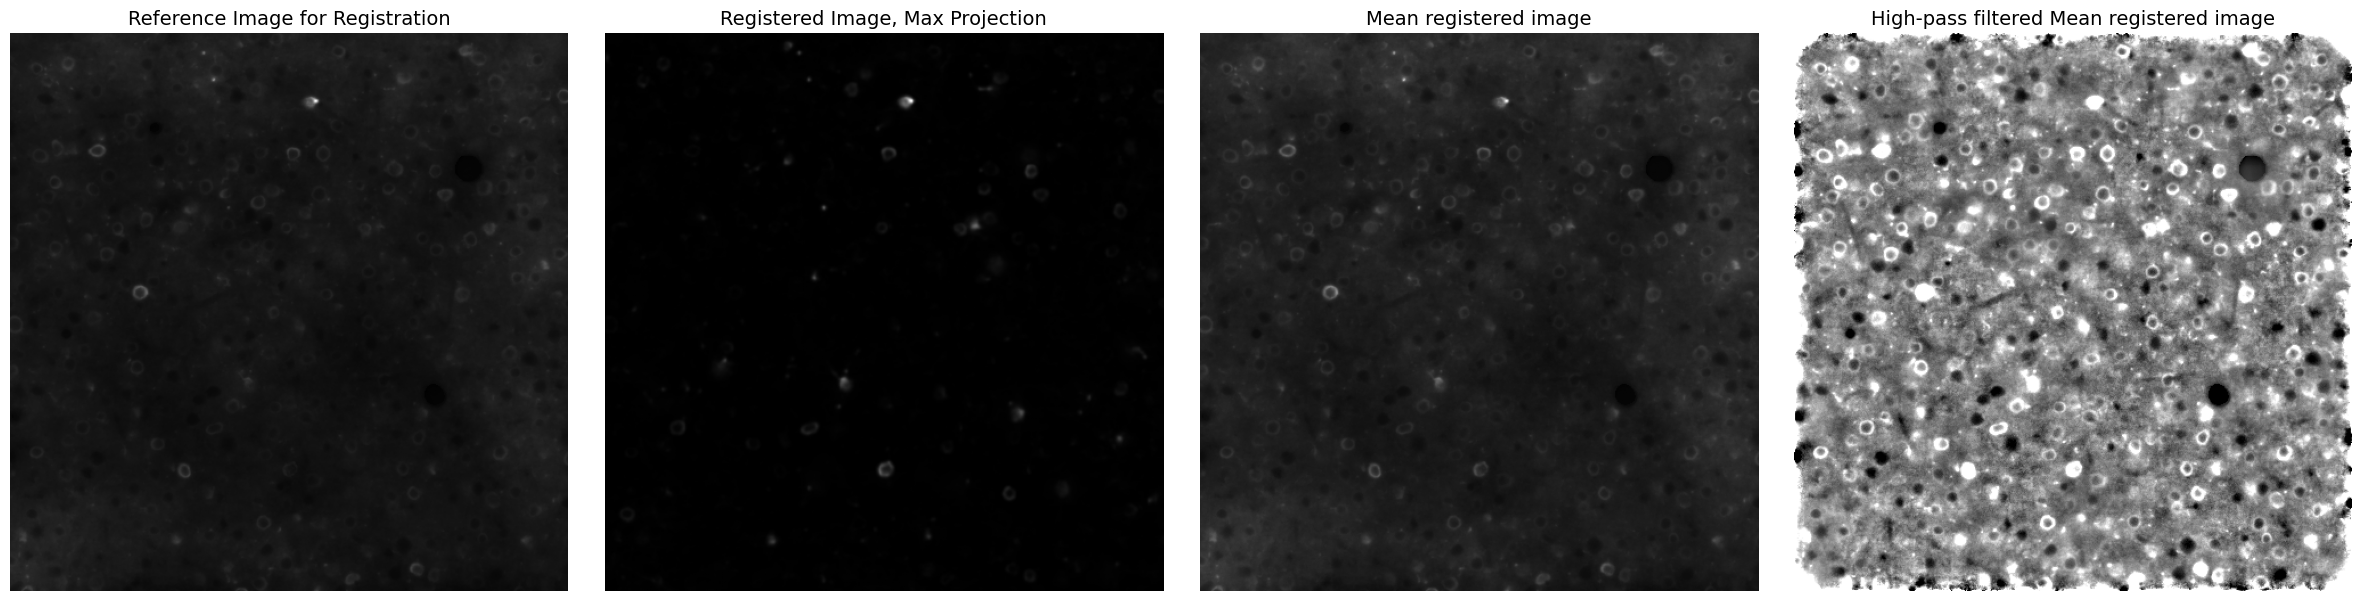

In [122]:
imshow(
    {
        "Reference Image for Registration": ops["refImg"],
        "Registered Image, Max Projection": ops["max_proj"],
        "Mean registered image": ops["meanImg"],
        "High-pass filtered Mean registered image": ops["meanImgE"],
    },
    size=6,
)

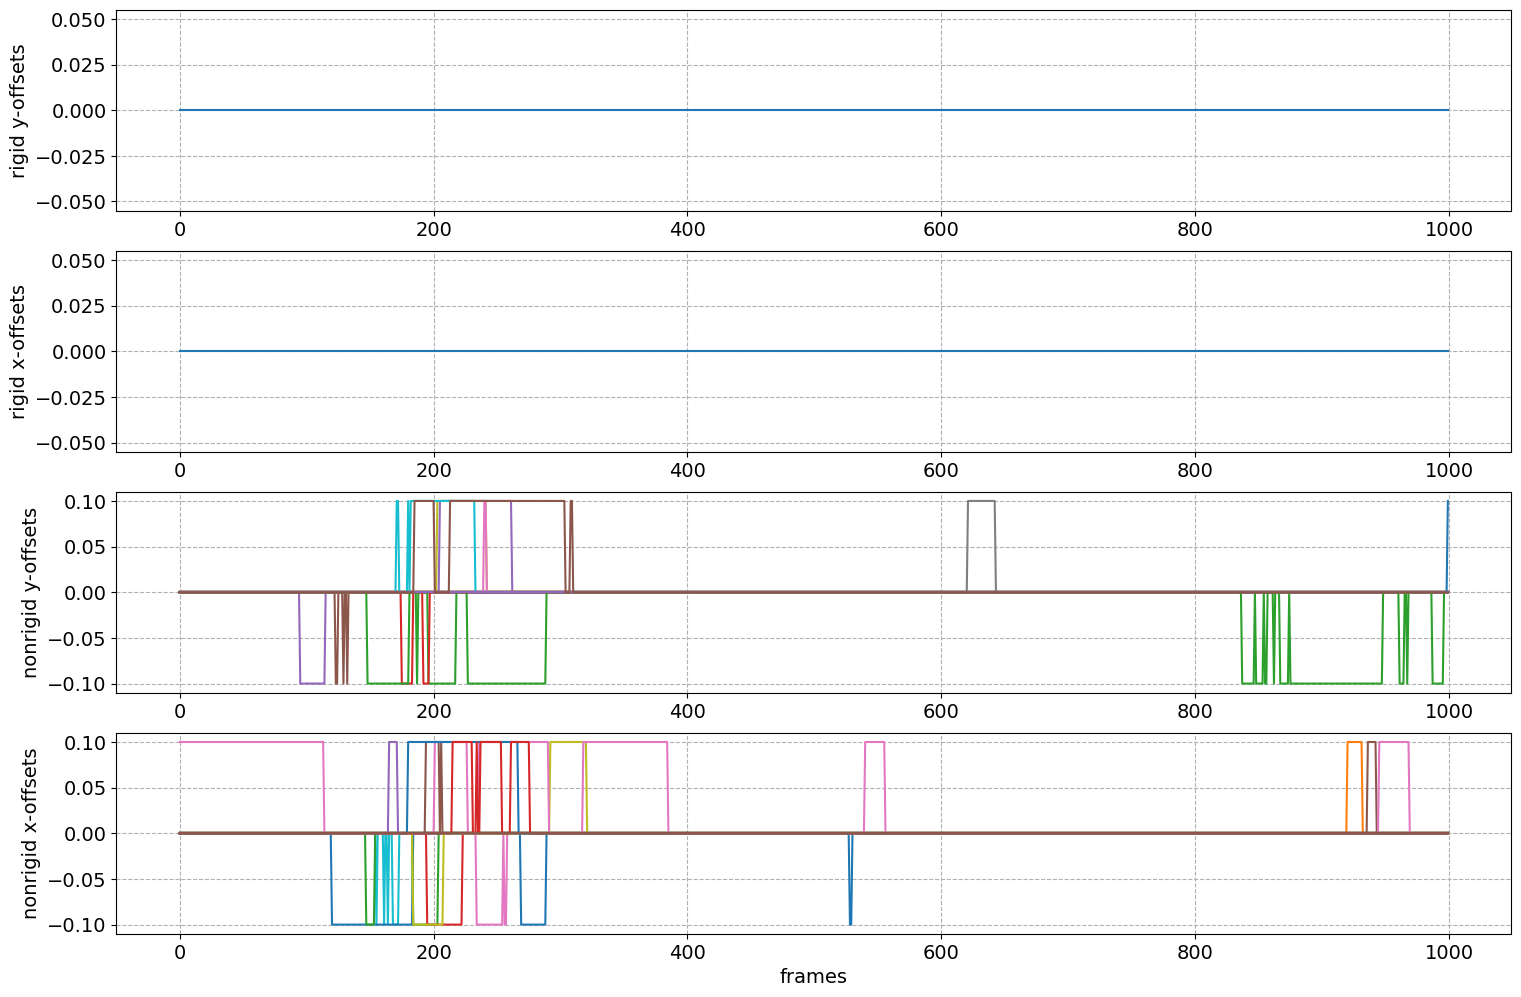

In [ ]:
plt.figure(figsize=(18, 12))

plt.subplot(4, 1, 1)
plt.plot(ops["yoff"][:1000])
plt.ylabel("rigid y-offsets")

plt.subplot(4, 1, 2)
plt.plot(ops["xoff"][:1000])
plt.ylabel("rigid x-offsets")

plt.subplot(4, 1, 3)
plt.plot(ops["yoff1"][:1000])
plt.ylabel("nonrigid y-offsets")

plt.subplot(4, 1, 4)
plt.plot(ops["xoff1"][:1000])
plt.ylabel("nonrigid x-offsets")
plt.xlabel("frames")

plt.show()

## Detection

ROIs are found by searching for sparse signals that are correlated spatially in the FOV. The ROIs are saved in `stat.npy` as a list of dictionaries which contain the pixels of the ROI and their weights (`stat['ypix']`, `stat['xpix']`, and `stat['lam']`). It also contains other spatial properties of the ROIs such as their aspect ratio and compactness, and properties of the signal such as the skewness of the fluorescence signal.

Some ROIs are defined as "cells" (somatic ROIs) or "not cells" (all other ROIs) depending on their properties, like skewness, compactness, etc. Below we will visualize the ROIs, but please open the files in the suite2p GUI for closer inspection.

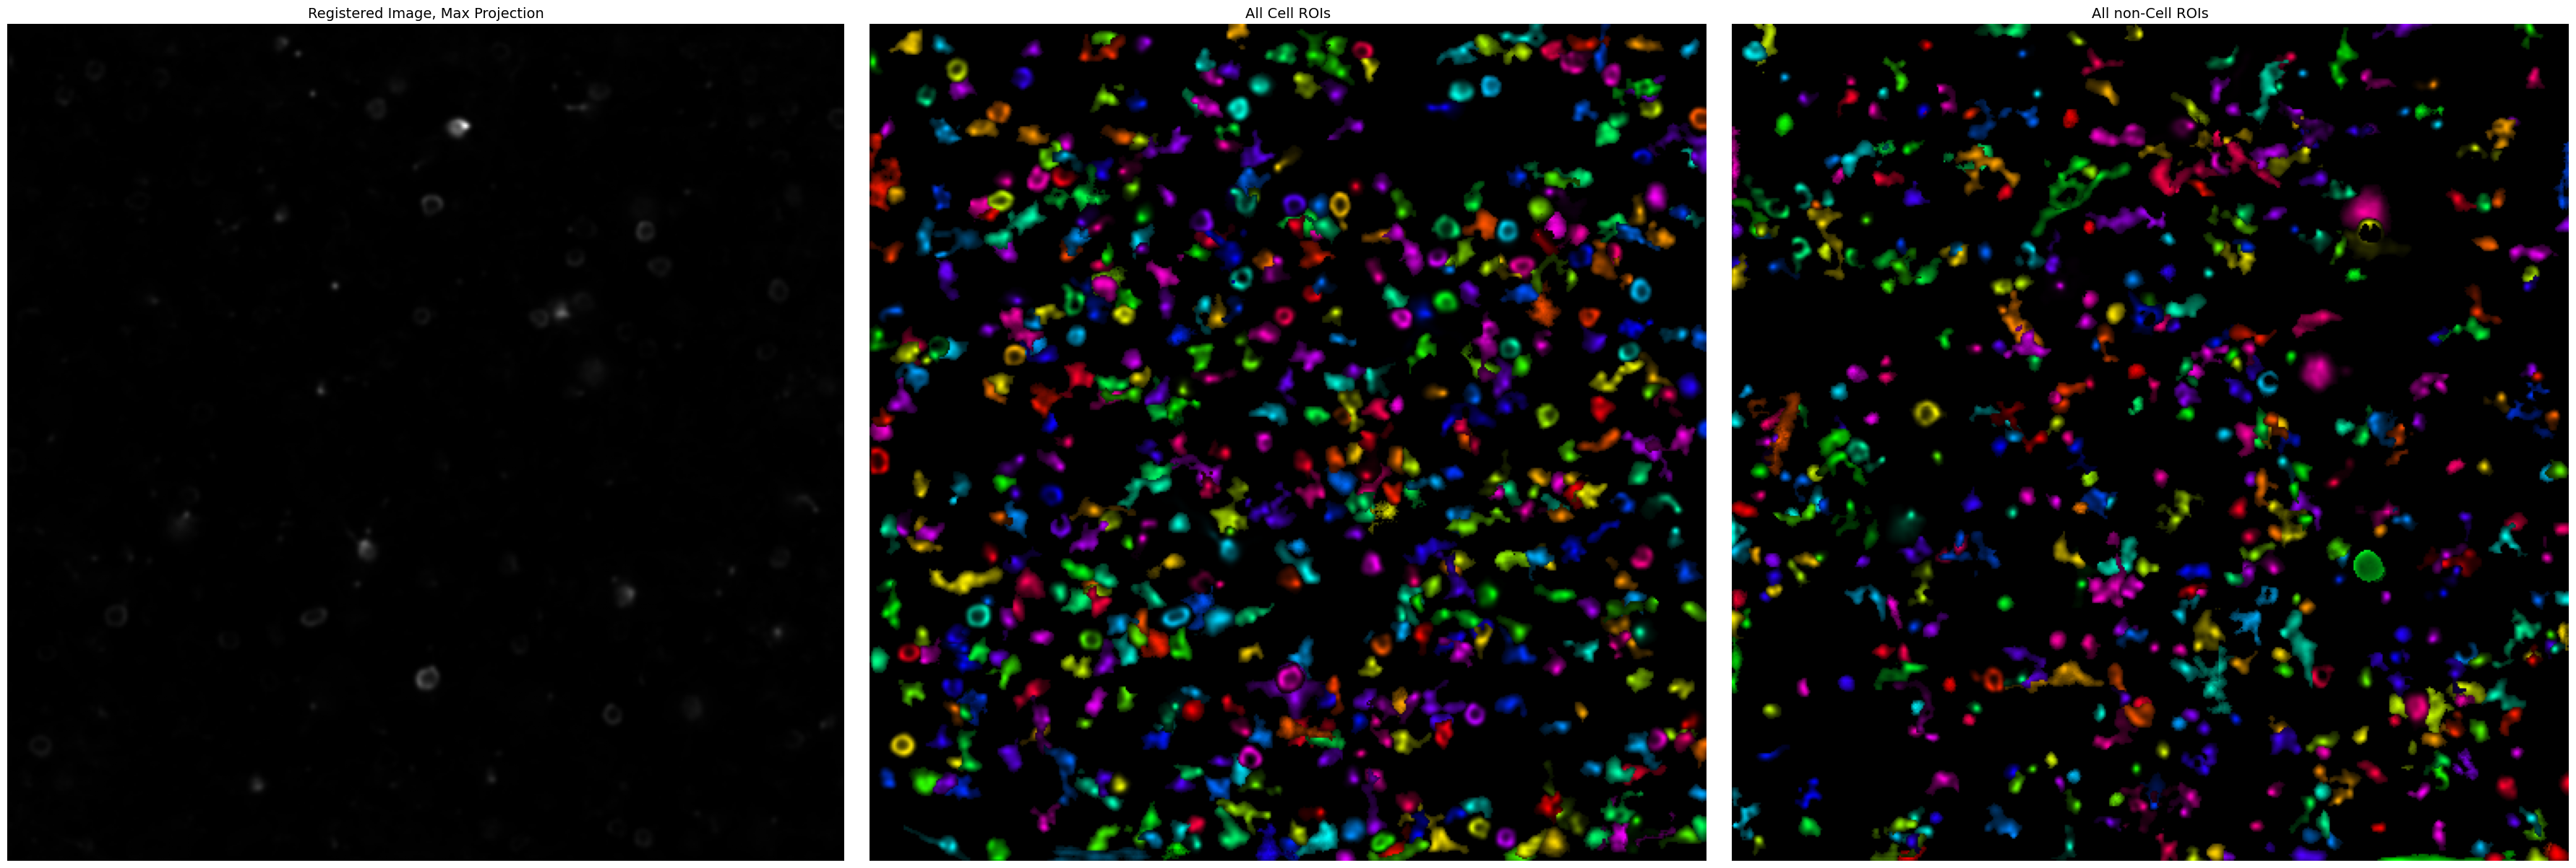

In [121]:
n_cells = len(stats)
h = np.random.rand(n_cells)
hsvs = np.zeros((2, Lx, Ly, 3), dtype=np.float32)

for i, stat in enumerate(stats):
    ypix, xpix, lam = stat["ypix"], stat["xpix"], stat["lam"]
    hsvs[iscell[i], ypix, xpix, 0] = h[i]
    hsvs[iscell[i], ypix, xpix, 1] = 1
    hsvs[iscell[i], ypix, xpix, 2] = lam / lam.max()

from colorsys import hsv_to_rgb

rgbs = np.array([hsv_to_rgb(*hsv) for hsv in hsvs.reshape(-1, 3)]).reshape(hsvs.shape)

imshow(
    {
        "Registered Image, Max Projection": ops["max_proj"],
        "All Cell ROIs": rgbs[1],
        "All non-Cell ROIs": rgbs[0],
    },
    size=12,
)

## Traces

We will load in the fluorescence, the neuropil and the deconvolved traces, and visualize them for a few cells.

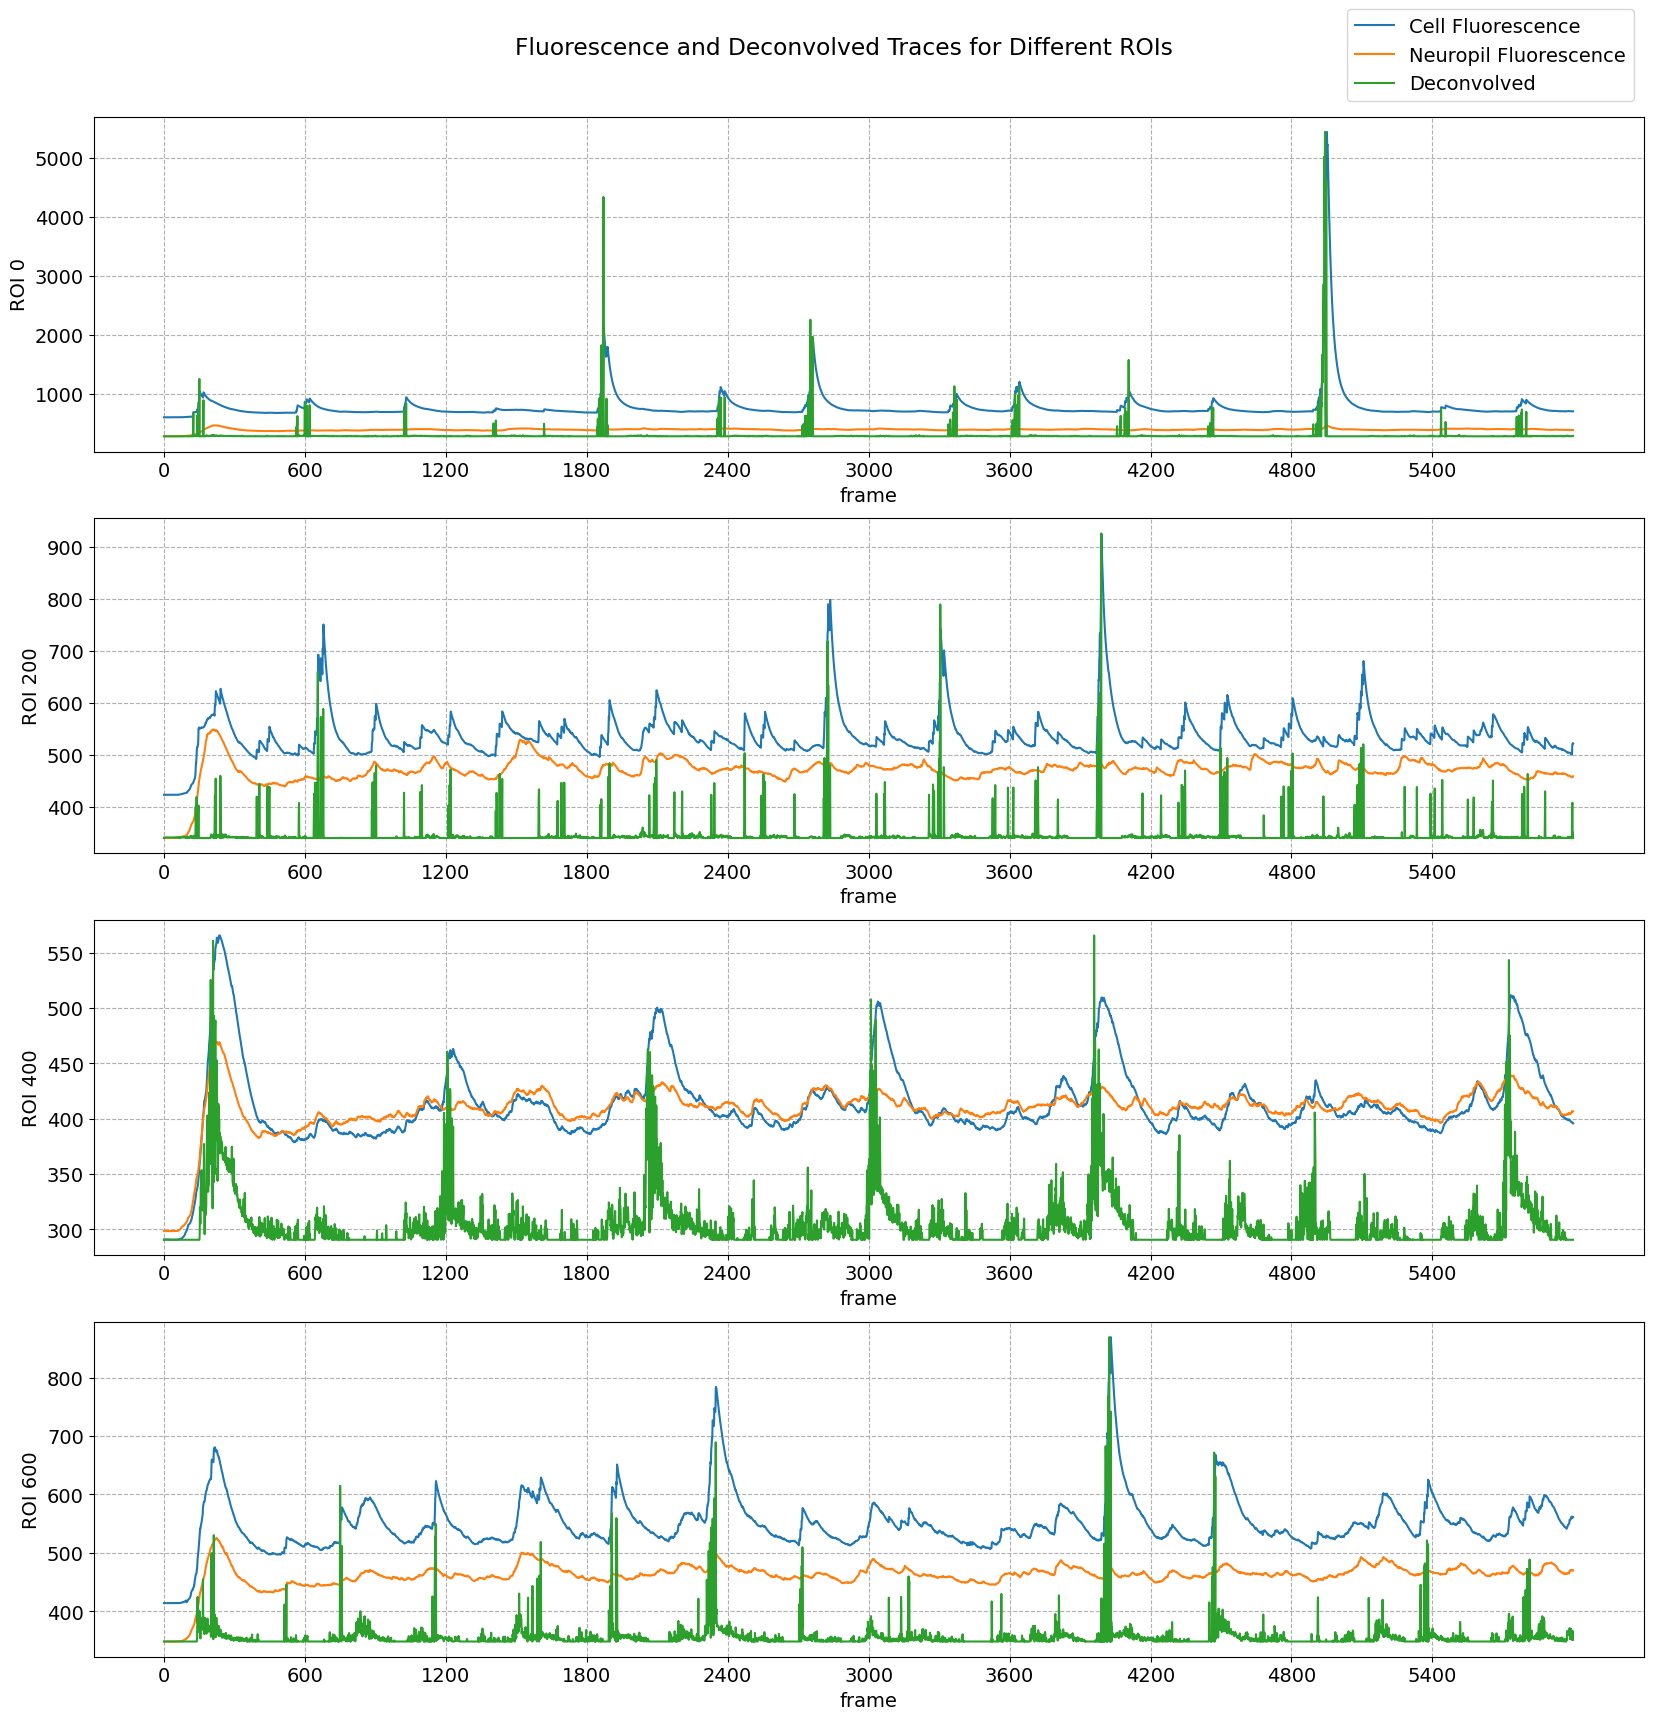

In [14]:
plt.figure(figsize=[20, 20])
plt.suptitle("Fluorescence and Deconvolved Traces for Different ROIs", y=0.92)
rois = np.arange(len(f_cells))[::200]
for i, roi in enumerate(rois):
    plt.subplot(len(rois), 1, i + 1)
    f = f_cells[roi]
    f_neu = f_neuropils[roi]
    sp = spks[roi]
    # Adjust spks range to match range of fluroescence traces
    fmax = np.maximum(f.max(), f_neu.max())
    fmin = np.minimum(f.min(), f_neu.min())
    frange = fmax - fmin
    sp /= sp.max()
    sp *= frange
    plt.plot(f, label="Cell Fluorescence")
    plt.plot(f_neu, label="Neuropil Fluorescence")
    plt.plot(sp + fmin, label="Deconvolved")
    plt.xticks(np.arange(0, f_cells.shape[1], f_cells.shape[1] / 10))
    plt.ylabel(f"ROI {roi}", rotation=90)
    plt.xlabel("frame")
    if i == 0:
        plt.legend(bbox_to_anchor=(1, 1.35))

# Metric Comparison

In [117]:
def barchart(baseline_df, df, label,width=0.75):
    fig, ax = plt.subplots(1, 1, figsize=(16, 8), sharey=False)

    ax.bar(baseline_df.index, baseline_df["val"], label="DeepCAD", color="lightgray", width=width)

    diff = df["val"] - baseline_df["val"]
    colors = np.where(diff < 0, "salmon", "steelblue")

    ax.bar(
        df.index,
        diff,
        bottom=baseline_df["val"],
        label=label,
        color=colors,
        width=width,
    )

    ax.set_ylim((.4, .8))
    ax.set_title("ROIs detection comparison")
    ax.set_xlabel("Metric")
    ax.legend()
    plt.tight_layout()
    plt.show()

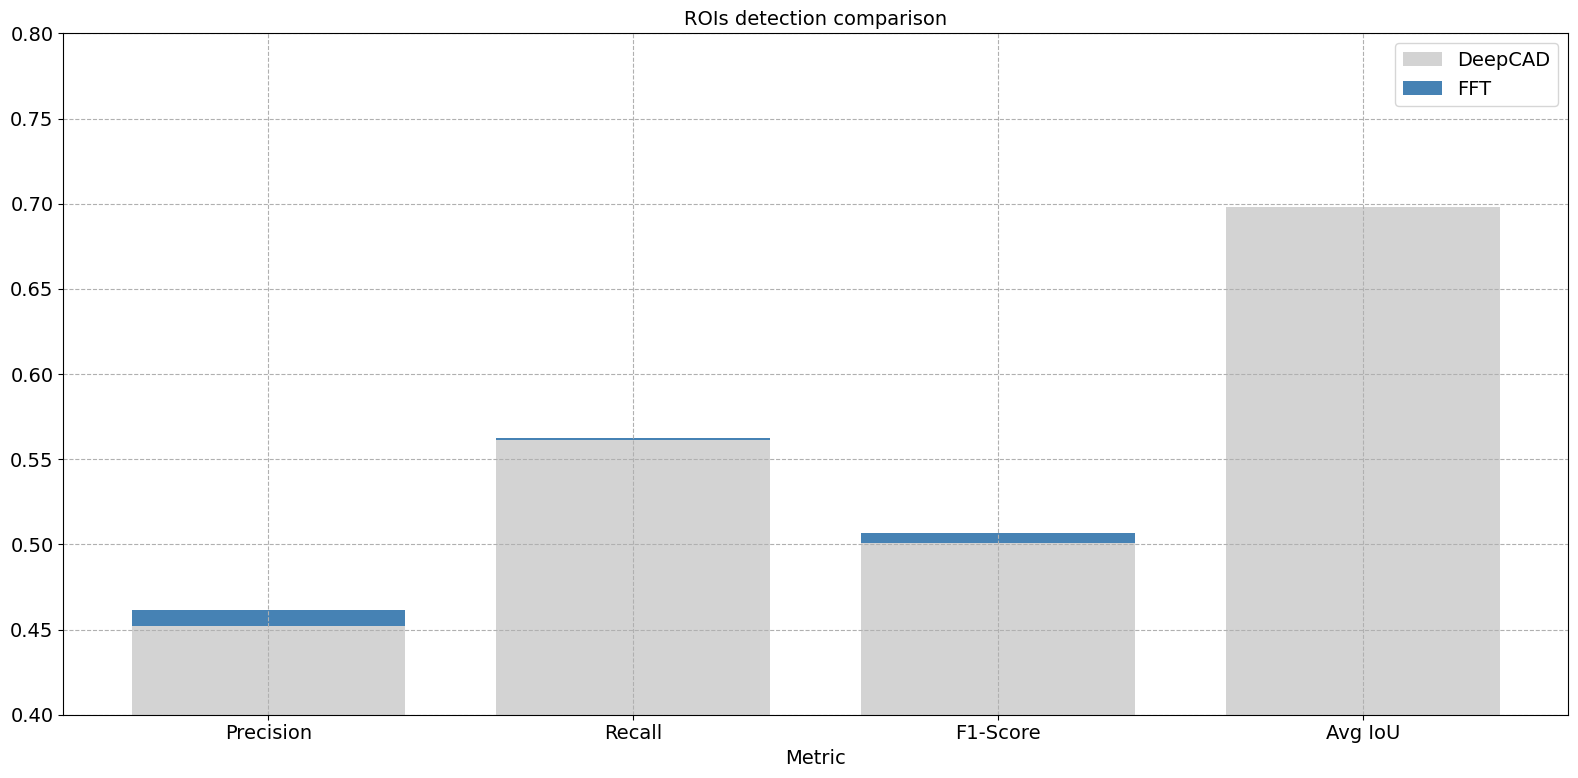

In [118]:
deepcad_30_df = pd.DataFrame(
    [
        ("Precision", 0.45195),
        ("Recall", 0.56111929),
        ("F1-Score", 0.5006570302233903),
        ("Avg IoU", 0.6979556530184408),
    ],
    columns=["Method", "val"],
).set_index("Method")
deepcad_15_df = pd.DataFrame(
    [
        ("Precision", 0.3702564102564102),
        ("Recall", 0.5316642120765832),
        ("F1-Score", 0.4365175332527207),
        ("Avg IoU", 0.6922321824881071),
    ],
    columns=["Method", "val"],
).set_index("Method")
deepcad_150_df = pd.DataFrame(
    [
        ("Precision", 0.5860979462875198),
        ("Recall", 0.5463917525773195),
        ("F1-Score", 0.5655487804878049),
        ("Avg IoU", 0.7120322268472281),
    ],
    columns=["Method", "val"],
).set_index("Method")
fft_30_df = pd.DataFrame(
    [
        ("Precision", 0.4613526570048309),
        ("Recall", 0.5625920471281296),
        ("F1-Score", 0.5069674850696748),
        ("Avg IoU", 0.6983227329995295),
    ],
    columns=["Method", "val"],
).set_index("Method")
fft_15_df = pd.DataFrame(
    [
        ("Precision", 0.3683673469387755),
        ("Recall", 0.5316642120765832),
        ("F1-Score", 0.4352019288728149),
        ("Avg IoU", 0.6941338615388822),
    ],
    columns=["Method", "val"],
).set_index("Method")
fft_150_df = pd.DataFrame(
    [
        ("Precision", 0.5996732026143791),
        ("Recall", 0.540500736377025),
        ("F1-Score", 0.56855151045701),
        ("Avg IoU", 0.7096467339733894),
    ],
    columns=["Method", "val"],
).set_index("Method")
x_df = pd.DataFrame(
    [
        ("Precision", 0.7166666666666667),
        ("Recall", 0.12665684830633284),
        ("F1-Score", 0.21526908635794742),
        ("Avg IoU", 0.6590019689781397),
    ],
    columns=["Method", "val"],
).set_index("Method")
# barchart(deepcad_30_df, x_df, width=0.75, label="Raw")
barchart(deepcad_30_df, fft_30_df, width=0.75, label="FFT")
# barchart(deepcad_150_df, fft_150_df, width=0.75, label="FFT")
# barchart(deepcad_15_df, fft_15_df, width=0.75, label="Deepcad 15")